In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [2]:
#reading dataset
exchange_data = pd.read_csv('forex_data_10y.csv')
exchange_data.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,25-Aug-20,74.327,74.100,74.335,74.075,0.92K,0.22%
1,24-Aug-20,74.168,74.922,74.922,73.962,4.90K,-1.01%
2,23-Aug-20,74.922,74.922,74.922,74.922,0,0.00%
3,21-Aug-20,74.920,74.980,75.005,74.820,3.16K,-0.12%
4,20-Aug-20,75.012,74.973,75.132,74.935,3.70K,0.22%


In [3]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [4]:
#checking first few records of the dataset
ind_exchange_data.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2020-08-25,74.327,74.100,74.335,74.075,0.92K,0.22%
2020-08-24,74.168,74.922,74.922,73.962,4.90K,-1.01%
2020-08-23,74.922,74.922,74.922,74.922,0,0.00%
2020-08-21,74.920,74.980,75.005,74.820,3.16K,-0.12%
2020-08-20,75.012,74.973,75.132,74.935,3.70K,0.22%


In [5]:
# sorting the dataset in ascending order of date
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Chg%,High,Low,Open,Price,Volume
Date,,,,,,
2010-09-13,0.05%,46.415,46.100,46.220,46.310,0
2010-09-14,-0.09%,46.465,46.070,46.270,46.270,0
2010-09-15,-0.15%,46.460,46.080,46.160,46.200,0
2010-09-16,-0.12%,46.415,46.075,46.145,46.145,0
2010-09-17,-0.63%,46.128,45.785,46.085,45.855,0


<AxesSubplot:xlabel='Date'>

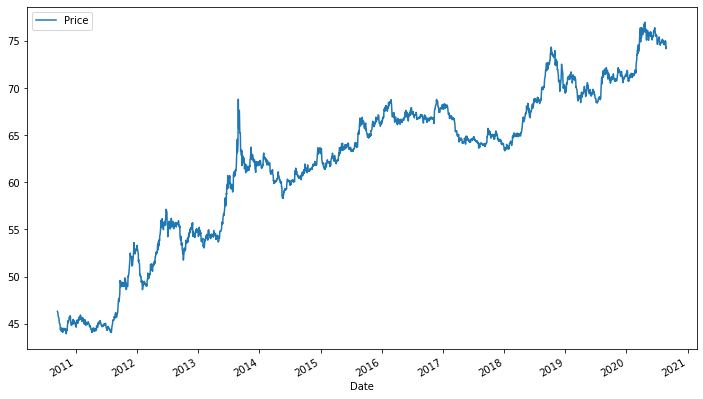

In [6]:
df = data_frame[["Price"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

In [7]:
diff = df.index.values[-1] - df.index.values[0]

days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))

Total data: 9 years
80 percent data = 2010 to 2017


In [8]:

df.describe()

,Price
count,2598.000000
mean,61.972875
std,8.449870
min,43.925000
25%,55.460000
50%,64.017500
75%,67.836500
max,76.975000


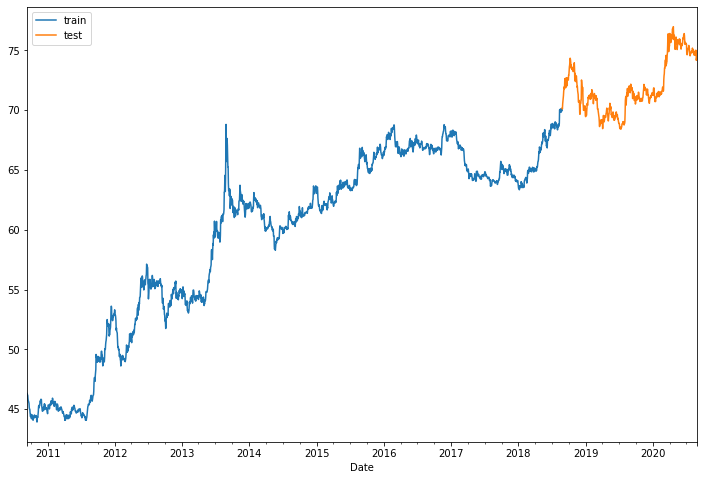

In [9]:
split_date = pd.Timestamp('26-08-2018')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [13]:
X_train.shape

(2074, 1)

In [14]:



print(len(X_train))

print(X_train.shape[0])
print(X_train.shape[1])



2074
2074
1


In [15]:
#Data pre processing required to turn it into a 3D array
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [18]:
from keras.layers import LSTM
from keras.layers import GRU

K.clear_session()

model_hybrid = Sequential()
model_hybrid.add(GRU(20, input_shape=(1,X_train.shape[1]), activation='linear', kernel_initializer='lecun_uniform', return_sequences=True))
model_hybrid.add(LSTM(50, activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_hybrid.add(Dense(64))
model_hybrid.add(Dense(1))
model_hybrid.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 20)             1380      
_________________________________________________________________
lstm (LSTM)                  (None, 50)                14200     
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 18,909
Trainable params: 18,909
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_hybrid.compile(loss=tf.keras.metrics.mean_squared_error, 
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_hybrid.fit(X_tr_t, y_train, epochs=100, batch_size =1, verbose=1, shuffle=False, callbacks=[early_stop])


Epoch 1/100
2074/2074 [==============================] - 2s 920us/step - loss: 0.0220 - rmse: 0.1483
Epoch 2/100
2074/2074 [==============================] - 2s 919us/step - loss: 0.0044 - rmse: 0.0667
Epoch 3/100
2074/2074 [==============================] - 2s 932us/step - loss: 0.0044 - rmse: 0.0664
Epoch 4/100
2074/2074 [==============================] - 2s 916us/step - loss: 0.0046 - rmse: 0.0677
Epoch 5/100
2074/2074 [==============================] - 2s 918us/step - loss: 0.0030 - rmse: 0.0547
Epoch 6/100
2074/2074 [==============================] - 2s 923us/step - loss: 0.0029 - rmse: 0.0538
Epoch 7/100
2074/2074 [==============================] - 2s 954us/step - loss: 0.0029 - rmse: 0.0541
Epoch 8/100
2074/2074 [==============================] - 2s 912us/step - loss: 0.0028 - rmse: 0.0526
Epoch 9/100
2074/2074 [==============================] - 2s 915us/step - loss: 0.0028 - rmse: 0.0530
Epoch 10/100
2074/2074 [==============================] - 2s 913us/step - loss: 0.0032 - rm

In [20]:
y_pred_test_hybrid = model_hybrid.predict(X_tst_t)
y_train_pred_hybrid = model_hybrid.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_hybrid)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_hybrid)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_hybrid)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_hybrid)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_hybrid)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_hybrid)))
r2_test = r2_score(y_test, y_pred_test_hybrid)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_hybrid)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Train set is:	0.845
The  MAE on the Train set is:	0.379
The  RMSE on the Train set is:	0.393
The Adjusted R2 score on the Train set is:	0.845

The R2 score on the Test set is:	0.945
The Adjusted R2 score on the Test set is:	0.945
The  MAE on the Test set is:	0.056
The  RMSE on the Test set is:	0.070


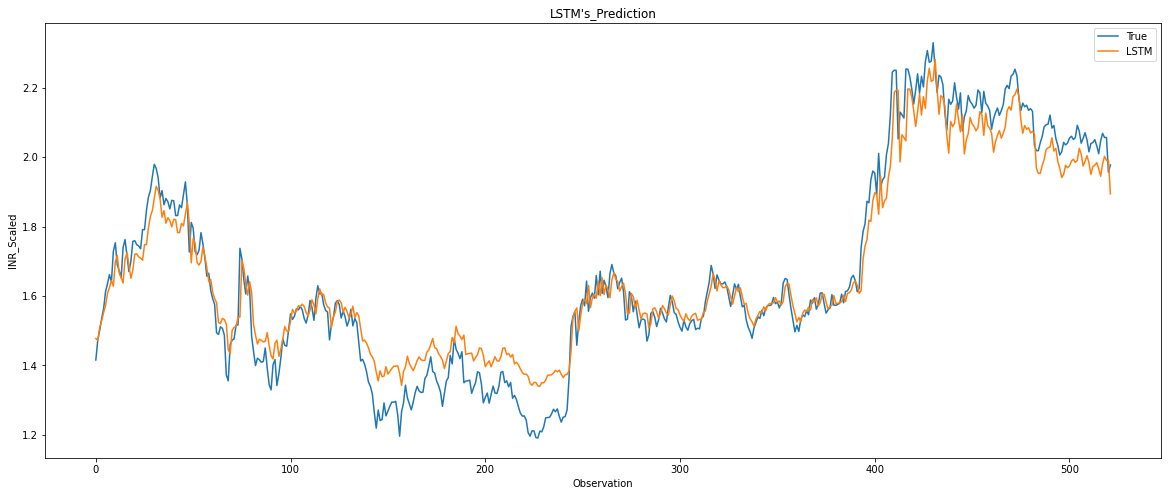

In [21]:
plt.figure(figsize=(20,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_hybrid, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [52]:

K.clear_session()


model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(20, return_sequences=False, activation='relu'), input_shape=(1,X_train.shape[1])))
model_bi.add(Dense(1))

model_bi.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 40)                3520      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 3,561
Trainable params: 3,561
Non-trainable params: 0
_________________________________________________________________


In [53]:
model_bi.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_bi = model_bi.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])


Epoch 1/100
2074/2074 [==============================] - 2s 873us/step - loss: 0.1894 - rmse: 0.4352
Epoch 2/100
2074/2074 [==============================] - 2s 846us/step - loss: 0.0029 - rmse: 0.0542
Epoch 3/100
2074/2074 [==============================] - 2s 852us/step - loss: 0.0017 - rmse: 0.0411
Epoch 4/100
2074/2074 [==============================] - 2s 843us/step - loss: 0.0018 - rmse: 0.0419
Epoch 5/100
2074/2074 [==============================] - 2s 850us/step - loss: 0.0018 - rmse: 0.0424
Epoch 6/100
2074/2074 [==============================] - 2s 859us/step - loss: 0.0018 - rmse: 0.0422
Epoch 7/100
2074/2074 [==============================] - 2s 823us/step - loss: 0.0018 - rmse: 0.0421
Epoch 8/100
2074/2074 [==============================] - 2s 820us/step - loss: 0.0018 - rmse: 0.0420
Epoch 00008: early stopping


In [54]:
y_pred_test_bi = model_bi.predict(X_tst_t)
y_train_pred_bi = model_bi.predict(X_tr_t)

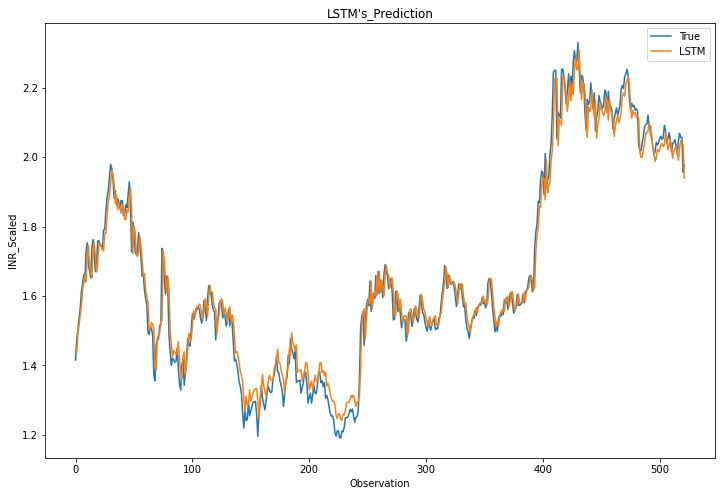

In [55]:




plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_bi, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()